<a href="https://colab.research.google.com/github/yurizza/Belajar-Pengembangan-Machine-Learning/blob/main/ImageClassification/6_animals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Image Classification: 6 Animals Classification
- Nama: Cici Yuriza
- Email: ciciyuriza999@gmail.com
- Id Dicoding: yuriza

In [ ]:
# Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import library
import os
import shutil
import zipfile
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# unzip folder in drive

# define folder path
zip_file_path = '/content/drive/MyDrive/animals.zip'

# define folder path for unzip folder
extracted_folder = '/content/drive/MyDrive/ImageClassification/'

# Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified folder
    zip_ref.extractall(extracted_folder)

In [ ]:
folder_path = '/content/drive/MyDrive/ImageClassification/animals'

# List all files in the folder
files = os.listdir(folder_path)

# Print the names of all files
for file in files:
    print(file)


butterfly
cat
chicken
cow
elephant
squirrel


In [ ]:
def display_image_sizes(folder_path, category):
    print(f"\nOriginal sizes of the first 5 images from the {category} folder:")

    # List all files in the folder
    image_files = os.listdir(os.path.join(folder_path, category))

    # Take the first 5 images
    selected_images = image_files[:5]

    # Display the original sizes of each image
    for image_name in selected_images:
        image_path = os.path.join(folder_path, category, image_name)
        image = Image.open(image_path)
        original_size = image.size
        print(f"Original size of the image {image_name}: {original_size}")

# Print the names of all files
for file in files:
    # Display the original sizes of the first 5 images in the 'animals' folder
    display_image_sizes(folder_path, file)


Original sizes of the first 5 images from the butterfly folder:
Original size of the image butterfly (1180).jpeg: (300, 224)
Original size of the image butterfly (1183).jpeg: (277, 194)
Original size of the image butterfly (1185).jpeg: (300, 239)
Original size of the image butterfly (1186).jpeg: (213, 300)
Original size of the image butterfly (1189).jpeg: (209, 300)

Original sizes of the first 5 images from the cat folder:
Original size of the image cat (515).jpeg: (300, 197)
Original size of the image cat (519).jpeg: (300, 219)
Original size of the image cat (52).jpg: (640, 426)
Original size of the image cat (526).jpeg: (300, 198)
Original size of the image cat (527).jpeg: (300, 224)

Original sizes of the first 5 images from the chicken folder:
Original size of the image chicken (1261).jpeg: (292, 300)
Original size of the image chicken (1265).jpeg: (300, 200)
Original size of the image chicken (1266).jpeg: (276, 300)
Original size of the image chicken (1267).jpeg: (300, 225)
Orig

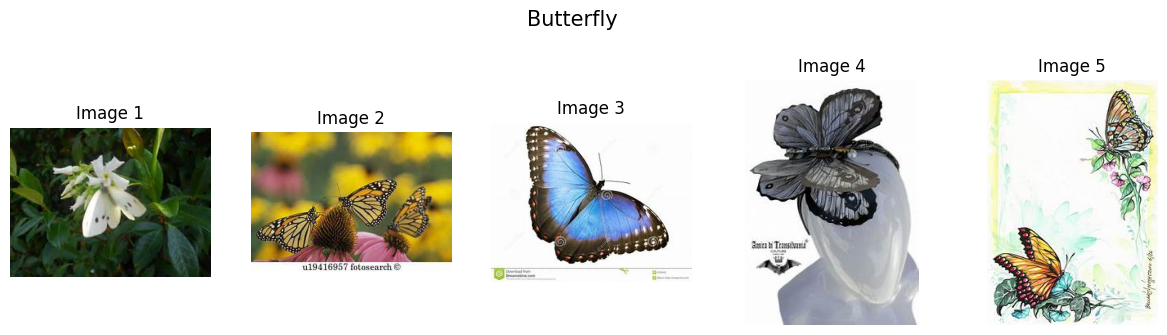

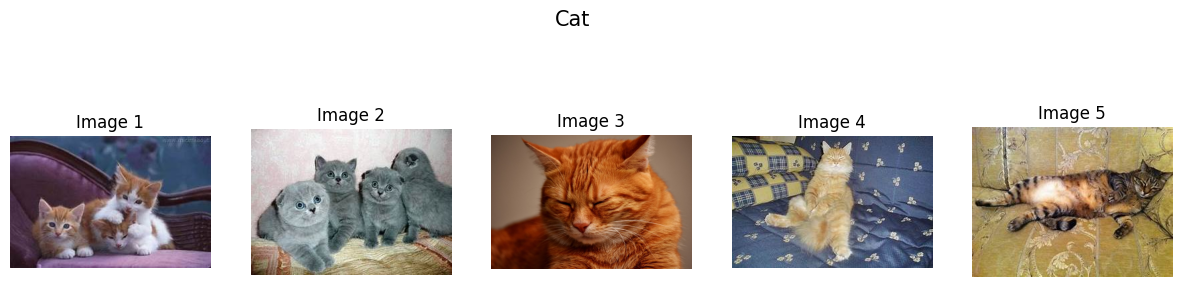

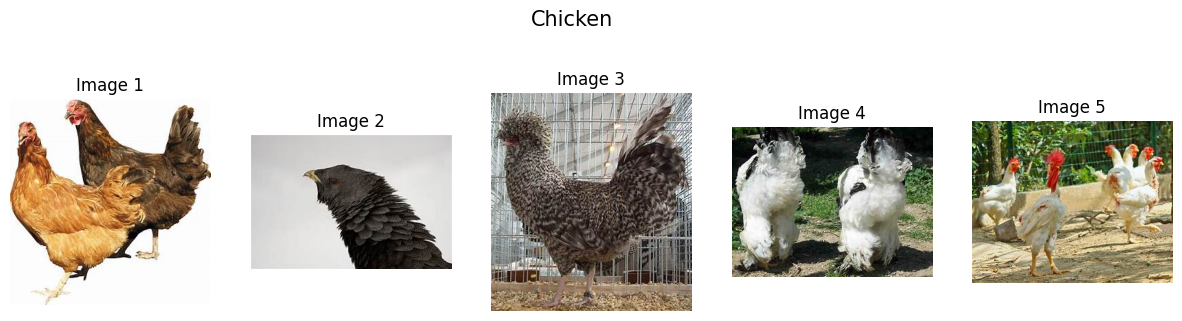

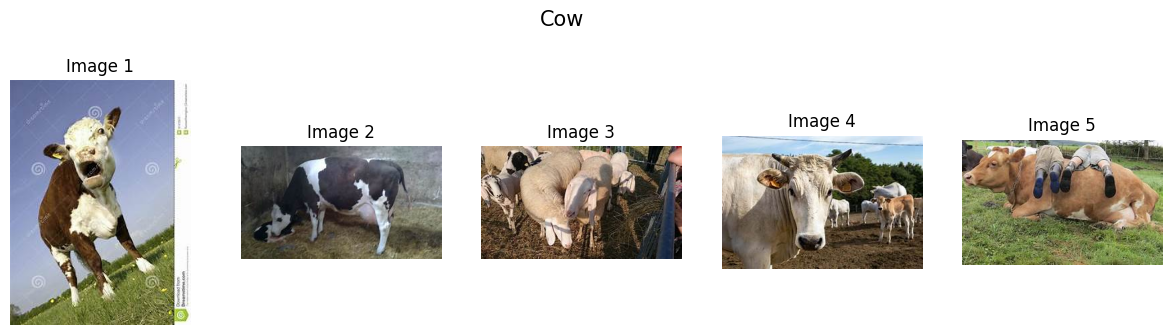

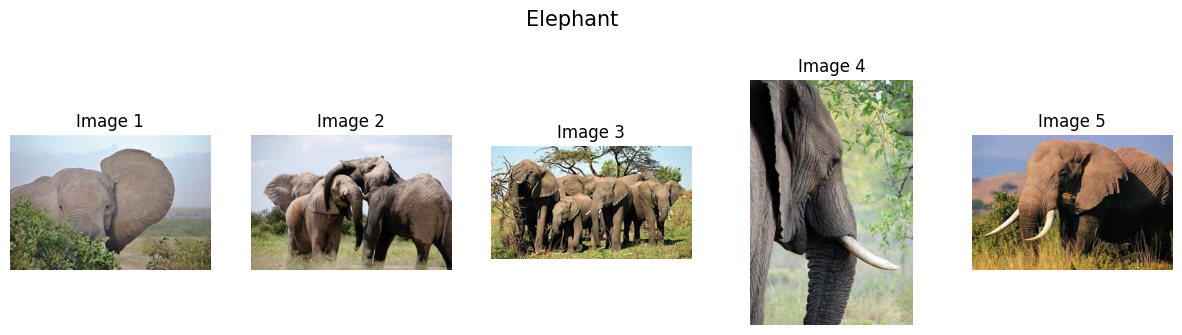

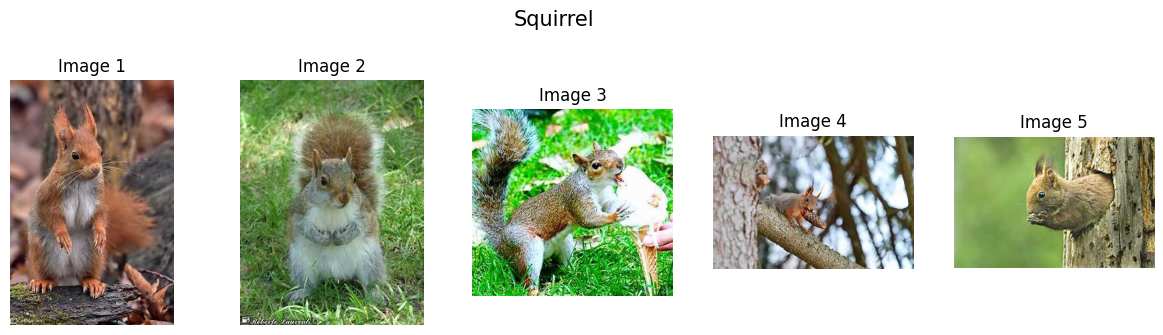

In [ ]:
# Display the images
# List all files in the folder
def display_image(folder_path, category):
    image_files = os.listdir(os.path.join(folder_path, category))

    # Take the first 5 images
    selected_images = image_files[:5]

    # Display the images in a horizontal 5x2 grid
    plt.figure(figsize=(15, 7))
    for i, image_name in enumerate(selected_images, 1):
        image_path = os.path.join(folder_path, category, image_name)
        image = Image.open(image_path)

        # Display the image
        plt.subplot(2, 5, i)
        plt.imshow(image)
        plt.title(f"Image {i}")
        plt.axis("off")

    # Set the category as the title
    plt.suptitle(category.capitalize(), fontsize=15)
    plt.show()

# Print the names of all files
for file in files:
    # Display the original sizes of the first 5 images in the 'animals' folder
    display_image(folder_path, file)


In [ ]:
# Show total data
print("=======================")
total_images = 0
for animal in files:
    images = len(os.listdir(f'{folder_path}/{animal}'))
    print(f'{animal} images: ', images)
    total_images += images
print("=======================")
print (f'Total Images : {total_images}')
print("=======================")

butterfly images:  2112
cat images:  1668
chicken images:  3098
cow images:  1866
elephant images:  1446
squirrel images:  1862
Total Images : 12052


Image Data Generator for:

Divided into train and test with ratio 80:20

Use augmentations such as :

- rescale
- rotation_range
- zoom_range
- brightness_range
- horizontal_flip

In [ ]:
# Setting up ImageDataGenerator for training data with various augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescaling pixel values to the range [0, 1]
    rotation_range=0.2,  # Random rotation of images within the range of 0 to 20 degrees
    zoom_range=0.2,  # Random zooming of images within the range of 0 to 20%
    brightness_range=[0.8, 1.2],  # Random adjustment of brightness within the range of 0.8 to 1.2
    horizontal_flip=True,  # Random horizontal flipping of images
    validation_split=0.2  # Splitting the data into training and validation sets, with 20% used for validation
)

# Setting up ImageDataGenerator for validation data
validation_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescaling pixel values to the range [0, 1]
    validation_split=0.2  # Splitting the data into training and validation sets, with 20% used for validation
)

In [ ]:
# Set up data generator for training
train_generator = train_datagen.flow_from_directory(
    folder_path,  # Path to the directory containing training images
    target_size=(224, 224),  # Resizing images to the specified dimensions
    batch_size=32,  # Number of samples per batch during training
    class_mode='categorical',  # Categorical classification for multi-class labels
    subset='training',  # Using the subset specified for training data
    shuffle=True,  # Shuffle the data during training
    seed=42  # Seed for reproducibility
)

# Set up data generator for validation
validation_generator = validation_datagen.flow_from_directory(
    folder_path,  # Path to the directory containing validation images
    target_size=(224, 224),  # Resizing images to the specified dimensions
    batch_size=1,  # Number of samples per batch during validation
    class_mode='categorical',  # Categorical classification for multi-class labels
    subset='validation',  # Using the subset specified for validation data
    shuffle=False  # Do not shuffle the data during validation
)


Found 9644 images belonging to 6 classes.
Found 2408 images belonging to 6 classes.


In [ ]:
# Display the class indices
print("Class Indices:", train_generator.class_indices)

Class Indices: {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'elephant': 4, 'squirrel': 5}


Define Model Machine Learning

In [ ]:
# Create a base model using ResNet50V2 architecture
base_model = ResNet50V2(
    input_shape=(224, 224, 3),  # Input shape of the images (height, width, channels)
    include_top=False,  # Exclude the fully-connected layers at the top of the network
    pooling='max'  # Use global max pooling as the pooling layer
)

In [ ]:
# Set all layers in the base_model to be non-trainable
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
# Defining Layers

# Create a Sequential model
model = Sequential()

# Add the pre-trained base_model (ResNet50V2) as the first layer
model.add(base_model)

# Add a Dense layer with 6 units and softmax activation as the output layer
model.add(Dense(6, activation='softmax'))


compile the model

In [ ]:
# Compile the model specifying loss function, optimizer, and evaluation metric
model.compile(loss='categorical_crossentropy',  # Using categorical cross-entropy for multi-class classification
              optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
              metrics=['accuracy'])  # Monitoring model accuracy during training

# Print the summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23577094 (89.94 MB)
Trainable params: 12294 (48.02 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


Define Reduce Learning Rate

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Monitor the validation accuracy for reducing the learning rate
    patience=3,                # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.2,                # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    min_lr=0.0000015           # Lower bound on the learning rate
)

Define Callback

In [ ]:
# Callback
# stop training when accuracy train and val accuracy reach more than 92%
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98
           and logs.get('val_accuracy') > 0.97):
            self.model.stop_training = True
            print("\nAkurasi dari training set dan validation set telah terpenuhi > 92%!")

callbacks = myCallback()

Training Model using 100 epoch

In [ ]:
# Train the model
history = model.fit(
    train_generator,  # Training data generator
    epochs=100,  # Number of training epochs
    validation_data=validation_generator,  # Validation data generator
    verbose=1,  # Set to 1 for progress bar, 0 for no logging during training
    callbacks=[callbacks, reduce_lr]  # List of callbacks to be applied during training
)


Epoch 1/100
302/302 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9929
Akurasi dari training set dan validation set telah terpenuhi > 92%!
302/302 [==============================] - 213s 706ms/step - loss: 0.0529 - accuracy: 0.9929 - val_loss: 0.3875 - val_accuracy: 0.9738 - lr: 8.0000e-06


Plot Accuracy and Loss Training and Testing

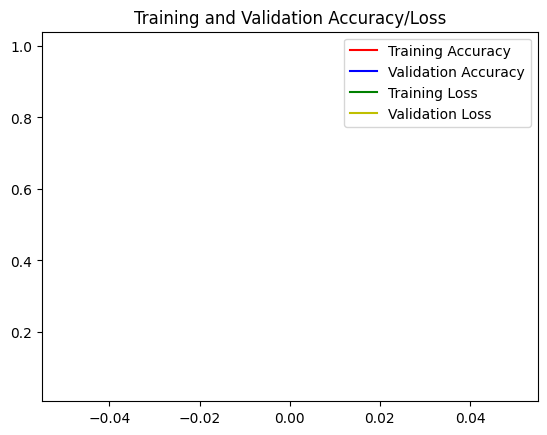

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']         # Training accuracy values
val_acc = history.history['val_accuracy'] # Validation accuracy values
loss = history.history['loss']             # Training loss values
val_loss = history.history['val_loss']     # Validation loss values

epochs = range(len(acc))  # Number of epochs

# Plot training and validation accuracy
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')

# Plot training and validation loss
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'y', label='Validation Loss')

plt.title('Training and Validation Accuracy/Loss')
plt.legend(loc=0)  # Place the legend at the best location
plt.figure()
plt.show()

In [ ]:
# Mendapatkan label sebenarnya pada data uji
true_labels = validation_generator.classes

# Menghitung jumlah sampel yang sesuai dari generator data uji
num_samples = len(validation_generator.classes)

# Mendapatkan prediksi untuk data uji
predictions = model.predict(validation_generator, steps=np.ceil(num_samples / validation_generator.batch_size), verbose=1)

# Mengonversi probabilitas menjadi label kelas
predicted_labels = np.argmax(predictions, axis=1)

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_labels[:num_samples], predicted_labels)

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(true_labels[:num_samples], predicted_labels, target_names=validation_generator.class_indices.keys()))

2408/2408 [==============================] - 36s 14ms/step
Confusion Matrix:
[[416   1   1   1   0   3]
 [  2 331   0   0   0   0]
 [  3   5 601   4   0   6]
 [  0   0   6 361   5   1]
 [  0   1   1   9 277   1]
 [  3   7   1   1   1 359]]

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.98      0.99      0.98       422
         cat       0.96      0.99      0.98       333
     chicken       0.99      0.97      0.98       619
         cow       0.96      0.97      0.96       373
    elephant       0.98      0.96      0.97       289
    squirrel       0.97      0.97      0.97       372

    accuracy                           0.97      2408
   macro avg       0.97      0.97      0.97      2408
weighted avg       0.97      0.97      0.97      2408



Saving Model to TF-Lite

In [ ]:
# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with tf.io.gfile.GFile('animals-6.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
tf.saved_model.save(model,'content/')

Testing Model

In [ ]:
# get filenames of image
filenames = validation_generator.filenames

In [ ]:
# get class name
class_indices = validation_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [ ]:
# Creating an empty DataFrame
val_df = pd.DataFrame()

# Adding the 'filename' column with file names
val_df['filename'] = filenames

# Adding the 'actual' column with actual labels
val_df['actual'] = true_labels

# Adding the 'predicted' column with predicted labels
val_df['predicted'] = predicted_labels

# Converting actual labels and predicted labels to their corresponding indices
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])

# Determining the 'Same' column indicating whether the prediction matches the actual label
val_df.loc[val_df['actual'] == val_df['predicted'], 'PredictionMatch'] = True
val_df.loc[val_df['actual'] != val_df['predicted'], 'PredictionMatch'] = False

# Shuffle the rows in val_df
val_df = val_df.sample(frac=1).reset_index(drop=True)

# Display the first 10 rows of the shuffled DataFrame
val_df.head(10)

filename     actual  predicted PredictionMatch
0      chicken/chicken (1146).jpeg    chicken    chicken            True
1       chicken/chicken (126).jpeg    chicken    chicken            True
2    squirrel/squirrel (1330).jpeg   squirrel   squirrel            True
3  butterfly/butterfly (1085).jpeg  butterfly  butterfly            True
4              cat/cat (1160).jpeg        cat        cat            True
5    squirrel/squirrel (1078).jpeg   squirrel   squirrel            True
6      chicken/chicken (1411).jpeg    chicken    chicken            True
7    elephant/elephant (1073).jpeg   elephant   elephant            True
8              cat/cat (1003).jpeg        cat        cat            True
9  butterfly/butterfly (1208).jpeg  butterfly  butterfly            True

In [ ]:
# Function to read an image from the given path
def read_image(path):
    # Load the image with RGB color mode and resize it to 224x224
    img = load_img(path, color_mode='rgb', target_size=(224, 224))
    img = img_to_array(img)
    # Normalize pixels to values between 0 and 1
    img = img / 255.

    return img

# Function to display images from the provided DataFrame
def display_images(temp_df):
    # Reset the DataFrame index
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0

    # Display the first 10 images in a 5x5 layout
    for i in range(20):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        # Read and display the image using the read_image function
        image = read_image(f"/content/drive/MyDrive/ImageClassification/animals/{temp_df.filename[i]}")
        plt.imshow(image)
        # Show the actual label (A) and predicted label (P) information as the image title
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

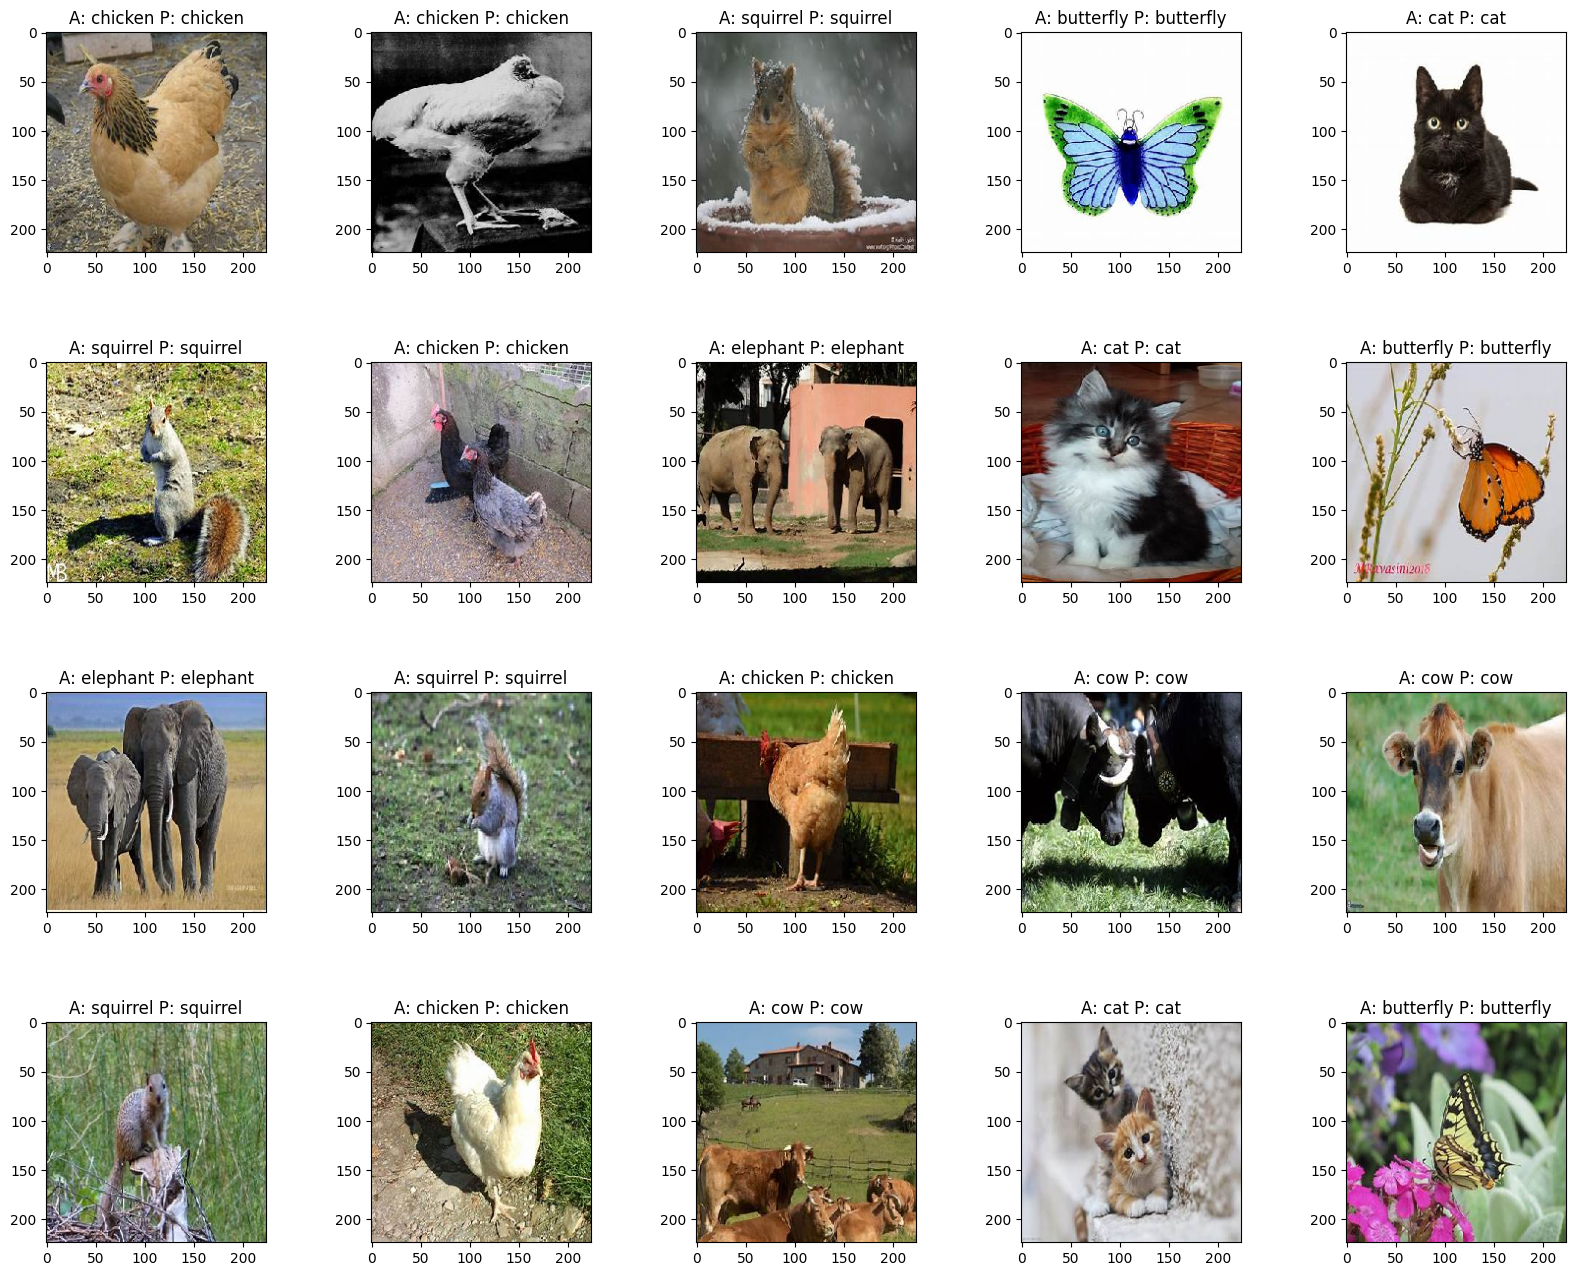

In [ ]:
# Call the function to display 20 images with correct classifications
display_images(val_df[val_df['PredictionMatch']==True])

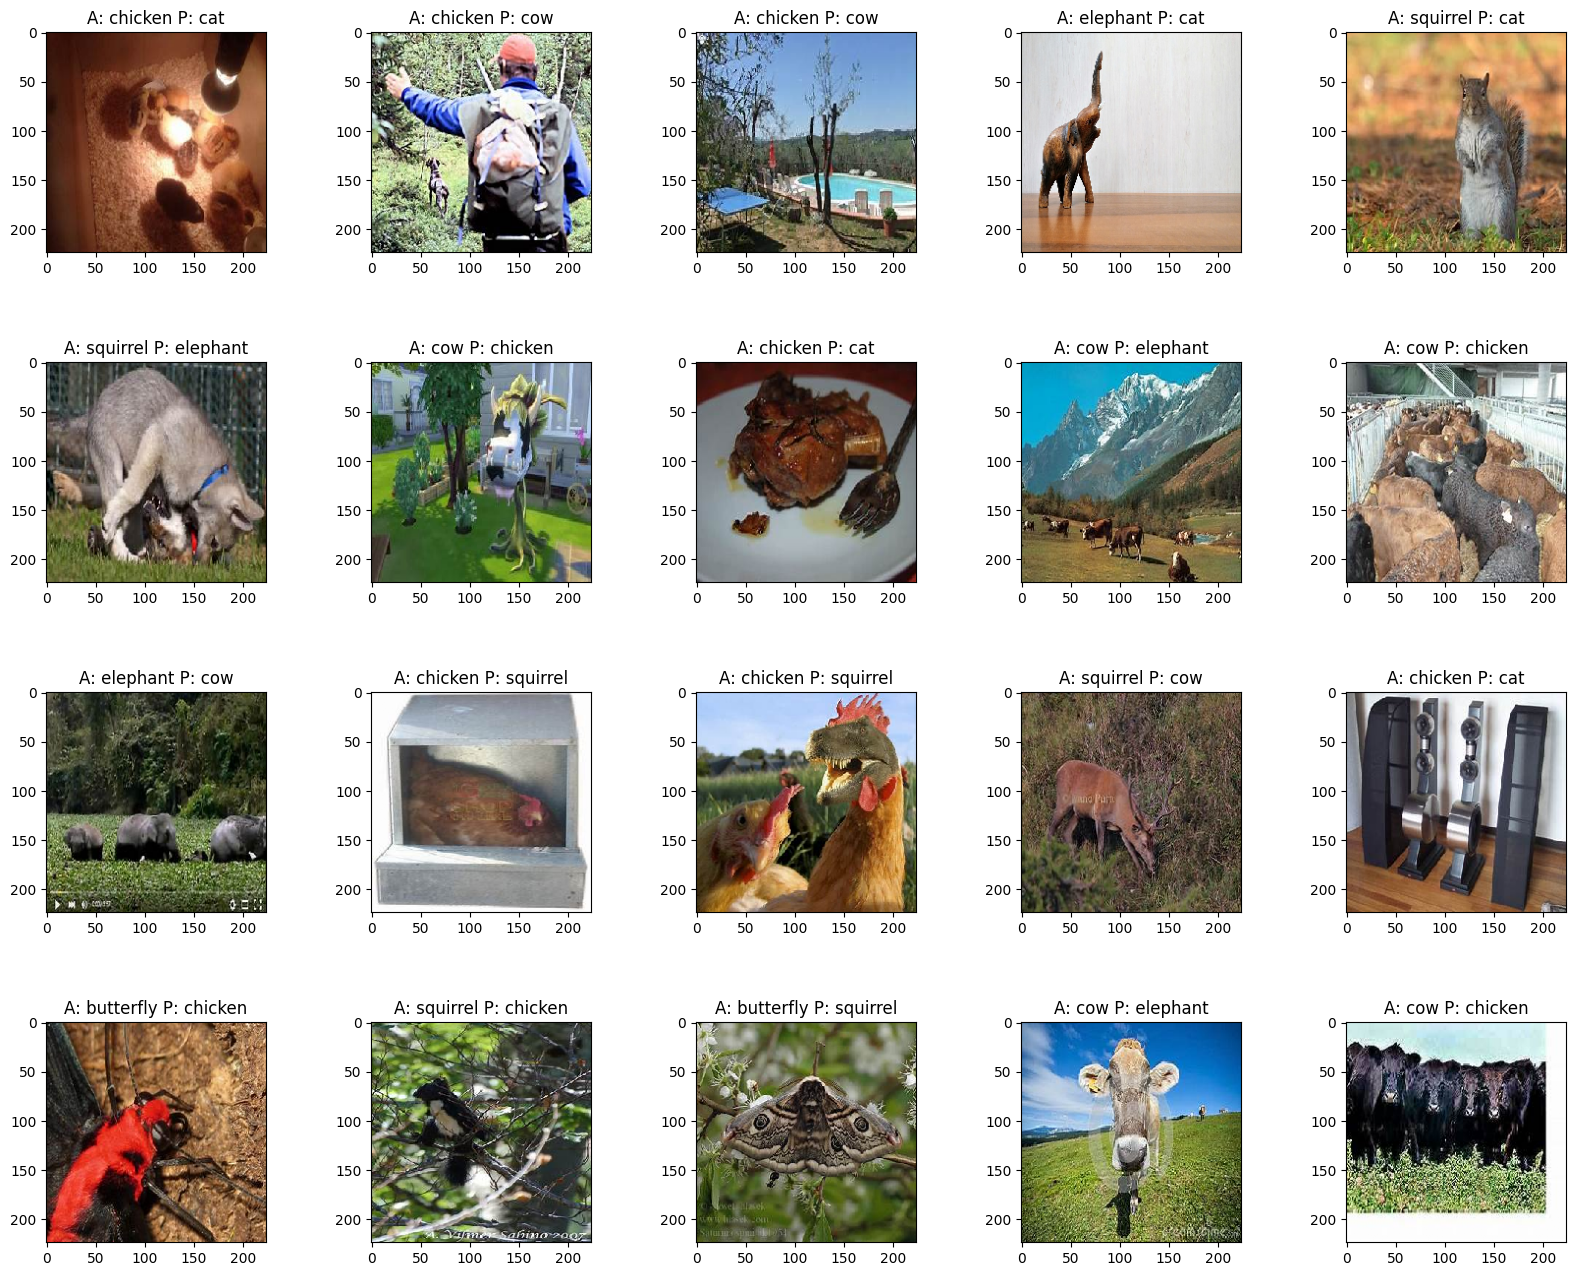

In [ ]:
# Call the function to display 20 images with incorrect classifications
display_images(val_df[val_df['PredictionMatch']==False])

Conclusion for 6 animals Classification:

1. The dataset utilized comprises a total of 12,052 images.
2. Augmentation techniques applied include rescaling, rotation range, zoom range, horizontal flip, and brightness range.
3. The dataset is divided into an 80:20 ratio for training and testing purposes.
4. The achieved accuracy is 0.9929 for train, validation accuracy is 0.9738 with loss is 0.4776 and validation loss is 0.3875.
5. The model is saved in TF-Lite format.